# Introduction

## Imports

In [ ]:
! pip install statsmodels
! pip install textstat
! pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 2.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.8 MB/s eta 0:00:00a 0:00:01m
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.9 MB/s eta 0:00:00a 0:00:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import textstat
from textblob import TextBlob

## Import the dataset

In [4]:
df_fake = pd.read_csv('data/Fake.csv')
df_real = pd.read_csv('data/True.csv')

# Wrangling

## Functions

### Building a wrapper for subjectivity/objectivity

the library we found for some of the functions doesn't work unless you initialize an object first so thats why we do this to apply the function

In [5]:
def subjectivity_objectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

def sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

### build a dictinoary of functions and names

do this to avoid redundant code during the runs for both dataframes. Could have avoided by just merging them but this is also cool

In [6]:
function_dict = {

    # complexity approaches
    'coleman_liau':textstat.coleman_liau_index,
    'smog':textstat.smog_index,

    # sentence length
    'sentence_length':textstat.avg_sentence_length,

    # subjectivity/objectivity
    'subjectivity':subjectivity_objectivity,

    # sentiment
    'sentiment':sentiment


}

In [7]:
for df in [df_fake,df_real]:
    for j in function_dict.keys():
        df[j] = df['text'].apply(function_dict[j])

### Combine the dataframes

In [8]:
df_fake['real'] = 0
df_real['real'] = 1
df = pd.concat([df_fake,df_real])
df_save = df.copy()

### drop the non-classification targets

In [9]:
df = df.drop(columns=['title','text','subject','date'])
df

,coleman_liau,smog,sentence_length,subjectivity,sentiment,real
0,9.05,11.8,17.0,0.599895,0.082132,0
1,11.95,12.9,16.9,0.334098,-0.005004,0
2,11.02,11.7,16.1,0.541969,-0.012345,0
3,11.19,13.0,17.6,0.394086,-0.023118,0
4,8.59,11.5,21.0,0.495222,-0.011722,0
...,...,...,...,...,...,...
21412,11.43,13.2,19.9,0.447884,0.219279,1
21413,13.05,13.8,20.7,0.077778,0.022222,1
21414,11.26,14.1,19.9,0.426609,0.054382,1
21415,10.51,13.0,22.7,0.377753,0.021993,1


In [10]:
df.dtypes

coleman_liau       float64
smog               float64
sentence_length    float64
subjectivity       float64
sentiment          float64
real                 int64
dtype: object

## EDA

### PCA Graph by Class

looks like there are some clear outliers in this dataset

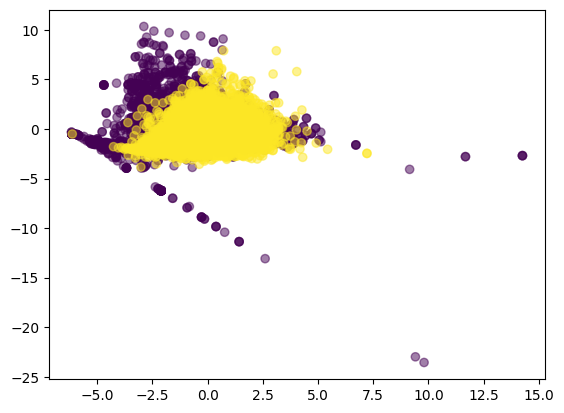

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# drop the real column
df_X = df.copy().drop(columns=['real'])
df_y = df.copy()['real']

# reassign (has no actual use)
X = np.array(df_X)
y=np.array(df_y)

# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# apply the pca
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

# wrangle the data
X_pca_df = pd.DataFrame(data=X_pca, columns=['pc1', 'pc2'])
final_df = pd.concat([X_pca_df, pd.DataFrame(y, columns=['real'])], axis=1)
# final_df = final_df.sample(frac=1).reset_index(drop=True)

# plot
plt.scatter(final_df['pc1'],final_df['pc2'],c=final_df['real'],alpha=.5)

#### finding pca outliers

In [12]:
final_df['pc1'].sort_values(ascending=False)

16042    14.256900
18429    14.256900
10531    14.256900
10119    11.676840
18117    11.676840
           ...    
12296    -6.128543
14320    -6.128543
12294    -6.128543
12333    -6.163195
19572    -6.163195
Name: pc1, Length: 44898, dtype: float64

### t-SNE

above looked bad so trying a t-SNE

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# drop the real column
df_X = df.copy().drop(columns=['real'])
df_y = df.copy()['real']

# reassign (has no actual use)
X = np.array(df_X)
y=np.array(df_y)

# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# apply the pca
tsne = TSNE(n_components=2,random_state=42)

tsne.fit(X)
X_tsne = tsne.fit_transform(X)

KeyboardInterrupt: 

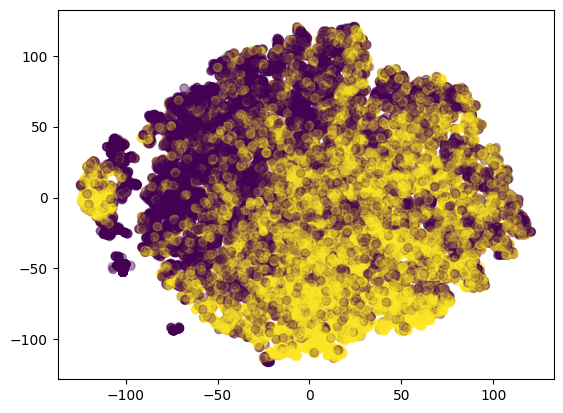

In [ ]:
# wrangle the data
X_tsne_df = pd.DataFrame(data=X_tsne, columns=['pc1', 'pc2'])
final_df = pd.concat([X_tsne_df, pd.DataFrame(y, columns=['real'])], axis=1)
final_df = final_df.sample(frac=1).reset_index(drop=True)

# plot
plt.scatter(final_df['pc1'],final_df['pc2'],c=final_df['real'],alpha=0.25)

### Worst articles

when you look at some of these they make no sense, and just are really long sentences, or articles that make no sense. These are also all fake news. This implies that there is bad fake data.

In [ ]:
df['smog'].sort_values(ascending=False).head(25)

18429    32.7
16042    32.7
10531    32.7
18117    29.5
10119    29.5
2639     29.0
17422    25.5
21862    25.5
15828    25.5
11715    24.6
11811    24.6
7277     23.8
15657    23.7
5967     23.7
7297     23.2
7248     22.8
17312    22.6
18135    22.5
10145    22.5
19775    22.1
12686    22.1
21055    21.7
16794    21.7
14566    21.7
9003     21.6
Name: smog, dtype: float64

In [ ]:
df_save[df_save.index == 18429].iloc[0]['real'],df_save[df_save.index == 18429].iloc[0]['text']

(np.int64(0),
 'Tennessee lawmakers have something to say to their counterparts in California and it s perfect! We could love this more Tennessee hits back at the loony state that banned all state travel to places that they think don t have the right policy in place. The response is epic: Whereas, California has passed legislation banning state sponsored travel to Tennessee and certain other states; andWhereas, the ban stems from legislation enacted by Tennessee that allows counselors to refer patients to other counselors who can better meet their goals, which the California State Legislature has judged to be morally reprehensible; andWhereas, California s attempt to influence public policy in our state is akin to Tennessee expressing its disapproval of California s exorbitant taxes, spiraling budget deficits, runaway social welfare programs, and rampant illegal immigration; andWhereas, Tennessee is pleasantly surprised that California will not be sending its economic development teams

In [ ]:
df_save[df_save.index == 10119].iloc[0]['real'],df_save[df_save.index == 10119].iloc[0]['text']

(np.int64(0),
 'An unidentified black Trump supporter blasted the Cudahy City, CA Council members over her objections to  racist  sanctuary cities. Her argument was based on her belief that sanctuary cities offer certain protections and benefits that are not even being offered to legal American citizens.Watch her amazing take down of the bleeding hearts who put lawbreaking foreign citizens before taxpaying and unemployed American citizens: Cities and CountiesCaliforniaAlameda County Berkley Contra Costa County Los Angeles County Los Angeles Monterey County Napa County Orange County Orange County Riverside County Sacramento County San Bernardino County San Diego County San Francisco County San Mateo County Santa Ana Santa Clara County Santa Cruz County Sonoma CountyColoradoArapahoe County Aurora Boulder County Denver County Garfield County Grand County Jefferson County Larimer County Mesa County Pitkin County Pueblo County Routt County San Miguel County Weld CountyConnecticutEast Haven 

In [ ]:
df_save[df_save.index == 2639].iloc[0]['real'],df_save[df_save.index == 2639].iloc[0]['text']

(np.int64(0),
 'In another of Donald Trump s whine rests, the Dictator in Chief accused the media of not reporting terrorist attacks. On Tuesday, Trump released the list of  unreported terrorist attacks,  which not surprisingly, have been extensively covered by the media. Yes, it s sad that lies from the White House are no longer surprising. What is surprising, though, is how the list was written. It was either done in a sleep deprived flurry from Trump or some drunken monkeys got ahold of a computer.You have to give the White House credit. For complete BS, the list is rather extensive. Here it is; see if you can find what s wrong.TIMELINE: September, 2014   December, 2016 NUMBER OF ATTACKS: 78MELBOURNE, AUSTRALIA September, 2014 TARGET: Two police officers wounded in knife attack ATTACKER: Abdul Numan HaiderTIZI OUZOU, ALGERIA September, 2014 TARGET: One French citizen beheaded ATTACKER: Jund al-Khilafah in AlgeriaQUEBEC, CANADA October, 2014 TARGET: One soldier killed and one wounded

In [ ]:
df_save[df_save.index == 17422].iloc[0]['real'],df_save[df_save.index == 17422].iloc[0]['text']

(np.int64(0),
 'Wow! What a list of accomplishments! The problem is that these accomplishments are rotten to the core. Just read a few and you ll get a taste of the corruption and Chicago style politics transplanted to D.C. via Obama. Not pretty!Law and Justice  First President to Violate the War Powers Act (Unilaterally Executing American Military Operations in Libya Without Informing Congress In the Required Time Period   Source: Huffington Post)  First President to Triple the Number of Warrantless Wiretaps of U.S. Citizens (Source: ACLU)   First President to Sign into Law a Bill That Permits the Government to  Hold Anyone Suspected of Being Associated With Terrorism Indefinitely, Without Any Form of Due Process. No Indictment. No Judge or Jury. No Evidence. No Trial. Just an Indefinite Jail Sentence  (NDAA Bill   Source: Business Insider)   First President to Refuse to Tell the Public What He Did For Eight (8) Hours After Being Informed That a U.S. Ambassador Was Facing Imminent Dea

In [ ]:
df_save[df_save.index == 11715].iloc[0]['real'],df_save[df_save.index == 11715].iloc[0]['text']

(np.int64(0), 'UPDATE VIDEO: Language alert:')

### best articles

In [ ]:
df_save[df_save['real'] == 1].sort_values(by='smog',ascending=True).head(25)

,title,text,subject,date,coleman_liau,smog,sentence_length,subjectivity,sentiment,real
14642,Suspicious object found with body in Stockholm...,STOCKHOLM (Reuters) - A man was found dead on ...,worldnews,"November 16, 2017",11.27,0.0,35.5,0.485000,0.095000,1
17001,Putin says Russia will respond in kind if U.S....,"SOCHI, Russia (Reuters) - Russia will respond ...",worldnews,"October 19, 2017",15.38,0.0,26.5,0.290909,0.042273,1
2236,Trump says he has not thought about firing Rus...,"BEDMINSTER, N.J. (Reuters) - U.S. President Do...",politicsNews,"August 10, 2017",12.08,0.0,35.5,0.532282,0.146691,1
4944,"FBI, NSA chiefs to testify on Trump wiretap cl...",WASHINGTON (Reuters) - Leaders of the House of...,politicsNews,"March 15, 2017",13.65,0.0,45.5,0.125000,0.125000,1
11052,Obama's legislative aide Fallon departs: White...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"January 29, 2016",12.49,0.0,37.5,0.125000,0.125000,1
19613,China says upholds peaceful resolution of Nort...,BEIJING (Reuters) - China supports a peaceful ...,worldnews,"September 20, 2017",11.49,0.0,28.5,0.202381,-0.023810,1
15502,Islamic State claims responsibility for attack...,CAIRO (Reuters) - Islamic State has claimed re...,worldnews,"November 7, 2017",13.36,0.0,48.0,0.375000,0.000000,1
17014,London will remain leading financial center: P...,LONDON (Reuters) - London will remain the worl...,worldnews,"October 19, 2017",12.20,0.0,41.5,0.158333,0.030000,1
971,White House continues to cooperate with specia...,WASHINGTON (Reuters) - Charges brought against...,politicsNews,"October 30, 2017",17.58,0.0,24.5,0.130804,0.016518,1
19595,"At least 10 dead, 92 missing in eastern Congo ...",ABIDJAN (Reuters) - At least 10 people have di...,worldnews,"September 20, 2017",12.54,0.0,34.0,0.175000,-0.165000,1


In [ ]:
df_save[df_save.index == 6354].iloc[1]['real'],df_save[df_save.index == 6354].iloc[1]['text']

(np.int64(1),
 'WASHINGTON (Reuters) - U.S. President Barack Obama surprised Vice President Joe Biden on Thursday by awarding him the Presidential Medal of Freedom with Distinction in an emotional White House ceremony that celebrated their partnership over eight years in office. “This is an extraordinary man,” Obama said of his friend and running mate at a surprise ceremony with staff, family and friends of the vice president.  “For the past eight years, he could not have been a more devoted or effective partner in the progress that we’ve made.” Biden, who was unaware that the ceremony would take place,  became visibly moved when Obama said he would bestow on him the highest civil honor in the United States.  It will be the last such award that Obama gives before he and Biden leave office on Jan. 20.  “I had no inkling,” Biden, 74, said after receiving the medal. “I get a lot of credit I don’t deserve,” he said, proceeding to give a roughly 20-minute impromptu speech thanking Obama and

## Analysis

### train test split

In [ ]:
from sklearn.model_selection import train_test_split

# drop the real column
df_X = df.copy().drop(columns=['real'])
df_y = df['real']

# reassign (has no actual use)
X = np.array(df_X)
y=np.array(df_y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


### Logistic Regression

In [ ]:
model = sm.Logit(y_train, X_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.600660
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                33673
Model:                          Logit   Df Residuals:                    33668
Method:                           MLE   Df Model:                            4
Date:                Wed, 09 Apr 2025   Pseudo R-squ.:                  0.1322
Time:                        17:06:43   Log-Likelihood:                -20226.
converged:                       True   LL-Null:                       -23307.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0094      0.002      4.917      0.000       0.006       0.013
x2             0.1201      0.004     30.130      0.000       0.112       0.128
x3             0.0493      0.002     22.019      0.000       0.045       0.054
x4            -7.1285      0.108    -66.255      0.000      -7.339      -6.918
x5             0.8282      0.135      6.155      0.000       0.564       1.092
==============================================================================
"""

### overfit detection

we didn't discuss any of the assumptions of LR so we have to check for overfitting

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

c_matrix = np.array([[0,0],
            [0,0]])

for i in range(0,len(y_test)):
    y_val = int(y_test[i])
    y_hat_val = int(y_pred[i])
    c_matrix[y_val][y_hat_val] += 1

# compute the accuracy
print(f'accuracy of the model: {(c_matrix[0][0] + c_matrix [1][1]) / c_matrix.sum() * 100}%')

# compute the f1 score

# pres is TP/(TP + FP)
pres = c_matrix[1][1] / (c_matrix[1][1] + c_matrix[0][1])

# recall is TP / (TP + FN)
recall = c_matrix[1][1] / (c_matrix[1][1] + c_matrix[1][0])
print
# f1 score
f1_score = (2 * pres * recall) / (pres + recall)
print(f'f1_score: {f1_score}')
print(f'confusion matrix: {c_matrix}')

accuracy of the model: 70.20935412026726%
f1_score: 0.6854778028592927
confusion matrix: [[4237 1658]
 [1686 3644]]


In [ ]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.copy().drop(columns=['real'])
y = df['real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


